In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import sympy

## Define Constants and Symbols

In [2]:
nu = 1 # per day
L = 1
E = 500000 # per L^2
R0 = 800/130
mu = 10 # per day
zeta = 1
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))

mean_distance = L/8
M = 1000
ell_min = 0.01
ell_max = mean_distance*2 # For uniform Distr. it does not make sense to go further, otherwise system becomes unimodal
ell_list = np.linspace(ell_min,ell_max,M)

In [3]:
s_A, s_av_d, s_av_b, s_beta, s_R0, s_mu, s_nu, s_E, s_ell, s_zeta = sympy.symbols(
    "A, av_d, av_b, β, R0, μ, ν, E, ℓ, ζ", real=True
)

## Define probability distributions

In [4]:
def inverseGammaDistUnnormalized(x, d_mean=mean_distance, k=3.1):
    if (x==0):
        return 0
    elif (x>L):
        return 0
    else:
        z = x/d_mean
        return (z**(-k))*np.exp(-(k-2)/z)


def uniformDist(x):
    A = mean_distance*2
    if (x>A):
        return 0
    else:
        return 1/A
    
normalization_uniform, _ = scipy.integrate.quad(uniformDist,0,np.infty)
assert np.isclose(1, normalization_uniform), "Should already be normalized"
normalization_inverse_gamma, _ = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)

print("Normalization factor for Uniform distribution: ", normalization_uniform)
print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

Normalization factor for Uniform distribution:  0.9999999999971505
Normalization factor for InverseGamma distribution:  0.10639395310187488


## Choose Probability Distribution and plot it

Integration Error:  2.460155579253609e-09


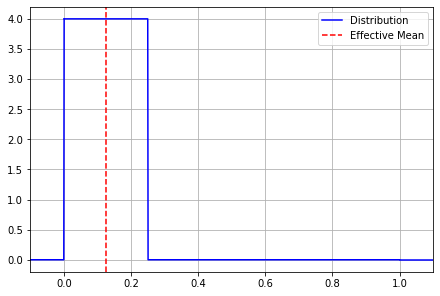

In [5]:
%matplotlib inline

# Either "uniformDist" or "inverseGammaDist"
probabilityDist = uniformDist

# Function for r*p(r)
rpr = lambda r : r*probabilityDist(r)

# Calculating Effective mean (resulting from cutting off Prob. Distr. at L)
effective_mean, error = scipy.integrate.quad(rpr, 0, np.infty)
print("Integration Error: ", error)

fig, ax = plt.subplots(constrained_layout=True)

x = np.linspace(0.001,L,1000)
probabilities = np.vectorize(probabilityDist)(x)
ax.plot(x, probabilities, label='Distribution', c='b')
ax.plot([-0.1,0,x[0]], [0,0,probabilities[0]], c='b')
ax.plot([x[-1],L,L+0.1], [probabilities[-1],0,0], c='b')
ax.axvline(effective_mean, ls='--', c='r', label='Effective Mean')
ax.grid()
ax.set_xlim(-0.1,L+0.1)
ax.legend()

plt.show()

In [6]:
print("Mean: ", mean_distance)
print("Effective Mean: ", effective_mean)

Mean:  0.125
Effective Mean:  0.12499999999570685


## Calculate Carbon Footprint

In [7]:
def delta_av_theory(delta_max, b, mode='mft'):
    delta_max = 1.5
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    if mode=='mft':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    elif mode=='bimodal_test':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))

    
def cummulative_prob(x):
    return scipy.integrate.quad(probabilityDist,0,x)[0]


def size(x,dx):
    return probabilityDist(x)*np.arccos(dx/x)/(2*np.pi)


def getCarbonIndex(ell, f, b, delta, R0, mu):
    dcar = nu*E*L*L*scipy.integrate.quad(rpr,0,np.infty)[0]
    dbus = (scipy.integrate.quad(rpr,0,zeta*ell)[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))*nu*E*L*L
    dtramr0 = 4*R0*mu*L*np.ceil(L/ell)
    
    Ci_drt = ((delta/b)*f)*dbus/dcar
    Ci_car = (1-f)*scipy.integrate.quad(rpr,0,np.infty)[0]*nu*E*L*L/dcar
    Ci_pt = dtramr0/dcar
    Ci = Ci_drt + Ci_pt + Ci_car
        
    return Ci, Ci_pt, Ci_drt, Ci_car, dcar


getCarbonIndexVectorized = np.vectorize(getCarbonIndex)


delta_av_theory = delta_av_theory(1.5, 2, mode='mft')

f = 1
av_drt_occs_non_standing = 2

Ci_theory, Ci_theory_pt, Ci_theory_drt, Ci_theory_car, _= \
    getCarbonIndexVectorized(ell_list, f, av_drt_occs_non_standing, delta_av_theory, R0, mu)

## Minimise symbolically
### Define Equations

In [8]:
a = s_A / (2*s_beta)
b = s_av_b*s_R0*s_mu*s_A/(s_av_d*s_beta**2*s_E*s_nu)

cubic_eq = s_ell**3 - a*s_ell**2 + b


# Define depressed cubic (same function, but centered at origin -
# Shift of +a/3)
p = -a**2/3
q = b - 2*a**3/27

depressed_cubic_eq = s_ell**3 + p*s_ell + q

discriminant = (q / 2) ** 2 + (p / 3) ** 3

print('Value of discriminant:')
display(
    discriminant.evalf(
        subs={
            s_nu: nu,
            s_E: E,
            s_R0: R0,
            s_mu: mu,
            s_zeta: zeta,
            s_beta: beta,
            s_av_b: av_drt_occs_non_standing,
            s_av_d: delta_av_theory,
            s_A: mean_distance*2,
        }
    ),
)


Value of discriminant:


-3.71678179745997e-7

### Minimise

In [9]:
sol = sympy.solve(depressed_cubic_eq, s_ell)
for s in sol:
    display(
        ((s+a/3).evalf(
            subs={
                s_nu: nu,
                s_E: E,
                s_R0: R0,
                s_mu: mu,
                s_zeta: zeta,
                s_beta: beta,
                s_av_b: av_drt_occs_non_standing,
                s_av_d: delta_av_theory,
                s_A: mean_distance*2,
            }
        ))/effective_mean,
    )

# ell_min_all_args = sympy.lambdify([s_nu,s_E,s_R0,s_mu,s_zeta,s_beta,s_av_b,s_av_d,s_A], sol[2], modules=["numpy"])
# print(ell_min_all_args(nu,E,R0,mu,zeta,beta,av_drt_occs_non_standing,delta_av_theory,mean_distance*2))
# ell_min = lambda μ: ell_min_all_args(nu,E,R0,μ,zeta,beta,av_drt_occs_non_standing,delta_av_theory,mean_distance*2)

# Above method does not work for some reason, so custom:
def ell_min_all_args(solution,nu,E,R0,mu,zeta,beta,av_b,av_d,A):
    sol_tupel = (solution.evalf(
            subs={
                s_nu: nu,
                s_E: E,
                s_R0: R0,
                s_mu: mu,
                s_zeta: zeta,
                s_beta: beta,
                s_av_b: av_b,
                s_av_d: av_d,
                s_A: A,
            }
        )).as_real_imag()
    
    result = np.real_if_close(float(sol_tupel[0]) + float(sol_tupel[1])*1j)
    assert np.isreal(result), "Returning a non real solution"
    return result

ell_min_of_mu = lambda mu: ell_min_all_args(sol[1]+a/3,nu,E,R0,mu,zeta,beta,av_drt_occs_non_standing,delta_av_theory,mean_distance*2)
print(ell_min_of_mu(mu)/effective_mean)

-0.234485480629375 + 5.2939559205212e-23*I

0.257824231638706 - 5.2939559205212e-23*I

2.59037164626029 + 1.3234889801303e-23*I

0.2578242316387065


## Plot carbon footprint

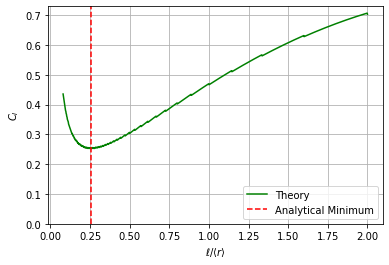

In [10]:
fig, ax = plt.subplots()
x_rescaled = ell_list/effective_mean
xlabel = r"$\ell/\langle r\rangle$"

ax.plot(x_rescaled, Ci_theory, "-", c='green', label="Theory")
ax.axvline(ell_min_of_mu(mu)/effective_mean, ls='--', c='r', label="Analytical Minimum")
ax.set_ylabel(r"$C_I$")

ax.set_xlabel(xlabel)
ax.legend()
ax.grid()

ax.set_ylim((0,None))

plt.show()

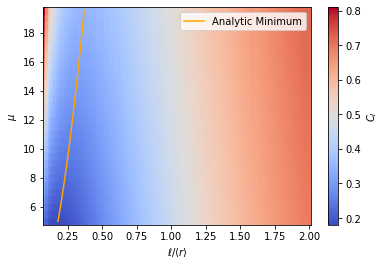

In [11]:
fig, ax = plt.subplots()

mu_range = np.arange(5,20,0.5)
ell_range = np.linspace(ell_min,ell_max,100)
ELL, MU = np.meshgrid(ell_range, mu_range)

CI_THEORY, _, _, _, _ = \
    getCarbonIndexVectorized(ELL, f, av_drt_occs_non_standing, delta_av_theory, R0, MU)

# ax.plot_surface(ELL/effective_mean, MU, CI_THEORY, cmap='coolwarm')
im = ax.pcolormesh(ELL/effective_mean, MU, CI_THEORY, cmap='coolwarm', shading='auto')
min_ells = np.vectorize(ell_min_of_mu)(mu_range)
min_CIs,_,_,_,_ = getCarbonIndexVectorized(min_ells, f, av_drt_occs_non_standing, delta_av_theory, R0, mu_range)
ax.plot(min_ells/effective_mean, mu_range, c='orange', label='Analytic Minimum')
ax.set_xlabel(r'$\ell/\langle r\rangle$')
ax.set_ylabel(r'$\mu$')
fig.colorbar(im, label=r'$C_I$')

ax.legend()

plt.show()

---
- For a high request frequency ($\nu E L^2$) and low $\ell$ the carbon index goes to zero
    - For given request frequency - what is a good tradeoff btw. convenience (increasing $\mu$) and emissions (decreasing $\mu$)?